In [1]:
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import display

import pandas as pd
import numpy as np
import json
import os

import DataMiner

pd.options.plotting.backend = "plotly"
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
O código-fonte deste notebook IPython é oculto por padrão para facilitar a leitura.
para mostrar/ocultar código fonte, clique <a href="javascript:code_toggle()">aqui</a>.''')

<img src="img/sthima_logo.jfif"
     alt="Markdown Monster icon"
     style="float: left; width:20%;" />
     
<img src="img/ATF.jfif"
     alt="Markdown Monster icon"
     style="width:40%;" />




# Score de Prospecção
____
>Este relatório apresenta uma analise complementar ao relatório DataAnalytics 1.0. Tendo como foco analisar outras variaveis e o impacto delas no modelo, este relatório nao irá se ater a conceitos presentes no relatório anterior

In [2]:
dbm = DataMiner.DataBaseManager()

cursor = dbm.get_all_base()
df = pd.DataFrame()

for document in cursor:
    df = df.append(document, ignore_index=True)
    
df['Resultado'] = df['Resultado'].replace({'Indefinido':np.nan})

In [3]:
def count_word(name):
    file_vactor = []
    
    count = 0
    for file_name in os.listdir('txtPuro/'):
        text = ""
        with open('txtPuro/'+file_name) as infile:
            for line in infile:
                text += line

        if text.count(name) >= 1:
            file_vactor.append(file_name)
            count+=1
            
    return count, file_vactor

In [4]:
null_columns = {}
null_columns['CINCO ULTIMAS'], v_CINCO = count_word('CINCO ULTIMAS')
null_columns['CONSULTAS A SERASA'], v_CONSULTAS = count_word('CONSULTAS A SERASA')
null_columns['HISTORICO DE PAGAMENTOS - VISAO CEDENTE'], v_HISTORICO = count_word('HISTORICO DE PAGAMENTOS - VISAO CEDENTE')
null_columns['EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE'], v_EVOLUCAO = count_word('EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE')
null_columns['REFIN'], v_REFIN = count_word('REFIN')
null_columns['PEFIN'], v_PEFIN = count_word('PEFIN')
null_columns['DIVIDA VENCIDA'], v_DIVIDA = count_word('DIVIDA VENCIDA')
null_columns['FALENCIA'], v_FALENCIA = count_word('FALENCIA')
null_columns['ACAO JUDICIAL'], v_ACAO = count_word('ACAO JUDICIAL')
null_columns['PROTESTO'], v_PROTESTO = count_word('PROTESTO')

null_columns = pd.Series(null_columns)

null_columns = null_columns.sort_values()

In [5]:
df_final = pd.DataFrame()
df_final['cnpj'] = df['cnpj']
df_final['txt_file'] = df['txt_file']
df_final['y'] = df['Resultado']

## Problemática
> Dado o problema do baixo volume de dados diagnosticádo no ultimo relatório, esse trabalho irá aproveitar as variaveis já encontradas encontradas:
> * Consultas de Crédito;
> * Consultas Recentes;
> * Total de Consultas;
> * Evolução de Compromissos;
> * Historico de Pagamentos.
>
> E irá adicionar 6 novos parámetros, representando a presença(**1**) e ausencia(**0**) daquela informção em cada variável(**CNPJ**), sendo eles:
> * REFIN
> * PEFIN
> * DIVIDA VENCIDA
> * FALENCIA
> * AÇÃO JUDICIAL
> * PROTESTO

In [6]:
aux_not_columns = [ (v_REFIN,'REFIN'),
                    (v_PEFIN,'PEFIN'),
                    (v_DIVIDA,'DIVIDA VENCIDA'),
                    (v_FALENCIA,'FALENCIA'),
                    (v_ACAO,'ACAO JUDICIAL'),
                    (v_PROTESTO,'PROTESTO')]

In [7]:
for i, j in aux_not_columns:
    df_final[j] = 0
    df_final.loc[df_final['txt_file'].isin(i), j] = 1


In [8]:
def consutlas_valores(line):
    
    try:
        aux_consultas = pd.DataFrame(line)
        count = 0

        for y in aux_consultas['EMPRESA']:
            if (y.find('RNX') >= 0) or (y.find('OPNIAO S/A') >= 0) or (y.find('FIDC') >= 0):
                count+=1

        return count
    except:
        return line

df_final['ConsultasCredito'] = df['CINCO ULTIMAS CONSULTAS'].apply(consutlas_valores)


def consultas_recentes(line):
    try:
        aux_consultas = pd.DataFrame(line)
        aux_consultas['QTD'] = aux_consultas['QTD'].astype(int)
        if aux_consultas['QTD'].iloc[0] > (aux_consultas['QTD'].median() + aux_consultas['QTD'].median()*0.3)\
            or aux_consultas['QTD'].iloc[1] > (aux_consultas['QTD'].median() + aux_consultas['QTD'].median()*0.3):
            return 1
        else:
            return 0
    except:
        return -1
    
df_final['ConsultasRecentes'] = df['REGISTRO DE CONSULTAS'].apply(consultas_recentes)


def total_consultas_recentes(line):
    try:
        aux_consultas = pd.DataFrame(line)
        aux_consultas['QTD'] = aux_consultas['QTD'].astype(int)
        return sum(aux_consultas['QTD'])
    except:
        return -1
    
df_final['Total_Consultas'] = df['REGISTRO DE CONSULTAS'].apply(total_consultas_recentes)
aux_plot = df_final['Total_Consultas'].value_counts()

def convert_value(a):
    try:
        v = []
        for n in a.split(' '):
            if str.isnumeric(n):
                v.append(int(n))
        if len(v) > 0:
            return np.max(v)
        else:
            return a
    except:
        return a

def clear_consultas(aux_consultas):
    if aux_consultas['MES/ANO'].iloc[-1].count('TOTAL') >= 1:
        aux_consultas = aux_consultas.iloc[:-1]

    for c in aux_consultas.columns[1:]:
        r = []
        for i in aux_consultas[c]:
            if i.count('-')>2:
                r.append(np.nan)
            else:
                v = convert_value(i)
                
                r.append(float(str(v).replace('.','')))
        aux_consultas[c] = r
        
    return aux_consultas

def evolucao_cedente(line):
    try:

        aux_consultas = pd.DataFrame(line)
        aux_consultas.columns = ['MES/ANO','VENCIDOS','A VENCER','TOTAL']
        aux_consultas = clear_consultas(aux_consultas)
        score = 0

        for i in range(0,len(aux_consultas)):
            if (aux_consultas.iloc[i]['VENCIDOS'] > 0) or (aux_consultas.iloc[i]['A VENCER'] > 0):
                if i < 3:
                    score += 0.8
                else:
                    score += 0.2

        return score
    except:
        return -1

    

df_final['EvolucaoCompromissos'] = df['EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE (VALORES EM R$)'].apply(evolucao_cedente)


def calculate_historico(line):
    
    try:
        aux_consultas = pd.DataFrame(line)
    except:
        return -1
    
    if len(aux_consultas) <=0 :
        return -1
    
#     print(aux_consultas)
    score_count = 0
    for i,j in aux_consultas.iterrows():
        if not(j['8-15_QTD'] is None):
            score_count+=0.3
            
        if not(j['16-30_QTD'] is None):
            score_count+=0.5
            
        if not(j['31-60_QTD'] is None):
            score_count+=0.7
            
        if not(j['+60_QTD'] is None):
            score_count+=0.9
            
    return score_count

df_final['HistoricoPagamentos'] = df['HISTORICO DE PAGAMENTOS - VISAO CEDENTE'].apply(calculate_historico)
aux_plot = df_final['HistoricoPagamentos'].value_counts()

In [9]:
df_final['y'] = df_final['y'].replace({'Insucesso':0, 'Sucesso':1})
df_final = df_final[df_final['y'].notnull()]

Amostra da base utizada:

In [10]:
df_final.head()

,cnpj,txt_file,y,REFIN,PEFIN,DIVIDA VENCIDA,FALENCIA,ACAO JUDICIAL,PROTESTO,ConsultasCredito,ConsultasRecentes,Total_Consultas,EvolucaoCompromissos,HistoricoPagamentos
0,95.816.963/0001-74,SERASA-R1059038.txt,0.0,1,1,1,1,1,1,0.0,0,187,4.6,-1.0
1,03.943.986/0001-21,SERASA-R1084436.txt,1.0,0,0,0,0,0,0,0.0,0,207,2.6,0.0
2,13.056.177/0003-13,SERASA-R1109513.txt,0.0,0,0,0,0,0,1,0.0,0,878,4.4,-1.0
3,78.099.777/0001-42,SERASA-R1146803.txt,1.0,0,1,1,0,0,1,0.0,1,561,4.4,-1.0
4,00.325.400/0001-77,SERASA-R114892.txt,0.0,1,1,0,0,0,1,0.0,0,177,4.6,-1.0


In [11]:
import matplotlib.pyplot as plt  
import random

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


import seaborn as sns

## Análise e Treinamento
> Aqui apresentamos a matriz de correlação entre as variáveis. 
> Importante salientar as relacionadas com o nosso *target*(**y**). Facilmente podemos ver que o resultado tem pouquissima relaçao com os parametros, exceto as informações de **HistoricoPagamentos** e **ConsultasRecentes** com uma correlação de aproximadamente **0.3**, sendo considerada uma relação baixa.
>
>Por outro lado, vemos uma relaçao grande entre os prametros de **REFIN**, **PEFIN** e **PROTESTO**, com uma correlação superior a **0.5**

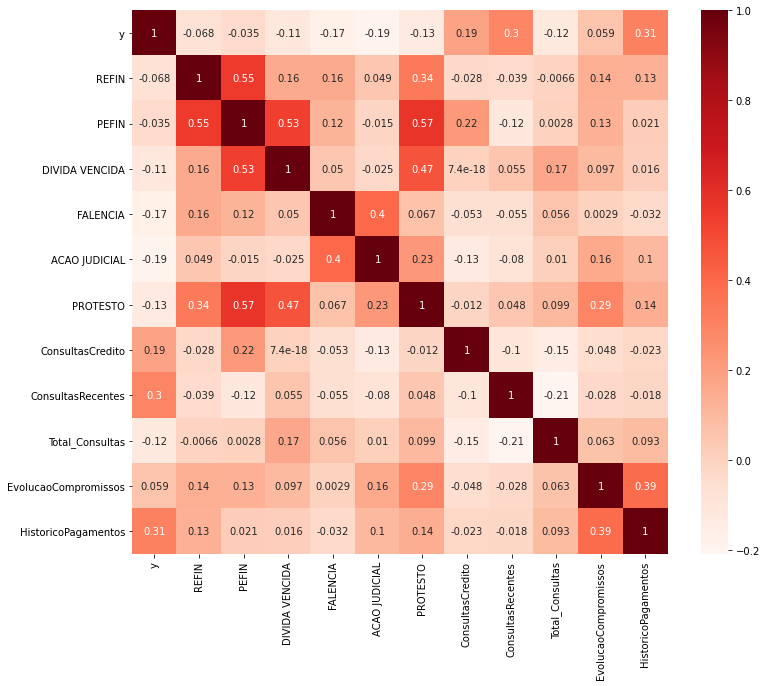

In [12]:
plt.figure(figsize=(12,10))
cor = df_final.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# XGBClassifier
> Dado o aumento de parámetros sendo boa parte deles binario, optei por realizar a classificação com um algoritmo baseado em árvores de decisão sendo ele o  *e***X***treme* ***G**radient* ***B**oosting* **Classifier**. Que utiliza um Gradiente Descendente em cima de uma árvore de decisão.

## Árvore de Decisão (*Decission Tree*)
> ![Alt Text](img/DecisionTree.png)
> O método de *Decission Tree* utiliza uma estrutura de árvore para determinar uma saida(representada por cada folha da árvore), através de diversas decisões encontradas em cada nó (ramificações ou galhos da árvore). Para montar uma árvore, é analisada a base de dados de entrada e gerada a sequência de perguntas e decisões tomadas. Sendo assim, uma mesma base pode gerar árvores diferentes com resultados igualmente diferentes, variando apenas a ordem das decisões tomadas. Dessa forma, surge a pergunta, como decidir e encontrar a melhor árvore ?
>
> Para isso é utilizado o Gradiente Descendente, que, de forma simplificada, combina diversas árvores "fracas" para gerar algo como um "comitê de decisão".
>___
> Sendo assim, abaixo podemos visualizar os resultados encontrado pelo modelo

In [13]:
X = df_final.drop(columns = ['cnpj','txt_file','y'])
y = df_final['y']

In [14]:


random_state = np.random.RandomState(11)
df_final = df_final.reset_index(drop = True)

X_train, X_test, y_train, y_test = train_test_split(X, \
                                                    y, \
                                                    test_size=0.25, random_state = random_state)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

y_result = model.predict(X_test)

sgd_ac = accuracy_score(y_test, y_result)
sgd_pr = precision_score(y_test, y_result, average='weighted')
sgd_rc = recall_score(y_test, y_result)
    
from IPython.display import display, Markdown, Latex
display(Markdown('>> * Accuracy: **'+"{:.2f}".format(sgd_ac)+'** \n >> * Precisão: **'+"{:.2f}".format(sgd_pr)+'** \n >> * Recal: **'+"{:.2f}".format(sgd_rc)+'7**'))

[21:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


>> * Accuracy: **0.86** 
 >> * Precisão: **0.86** 
 >> * Recal: **0.927**

>> Apesar dos resultados "piores" aos encontrados em Data Analytics 1.0, vale salientar que mais parametros foram utilizados podendo diminuir o desempenho do modelo para esse conjunto de dados. Entretanto para o intuito deste estudo uma accuracy de 86% demonstra ser satisfatória.

>> **Matriz de Confusão:**

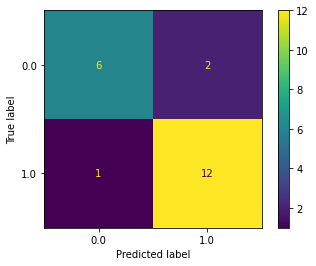

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

confusion_matrix(y_test, y_result)
plot_confusion_matrix(model, X_test, y_test)  
plt.show()  

# Análise e Interpretação do Modelo
> Nessa etapa se encontra o ponto chave desse relátorio, a utilização do Shap para analizar os resultados do modelo e encontrar informações uteis para o negocio e para etapas futuras.

## SHAP 


> O ***SH**apley* *Additive* *ex**P**lanations* é uma abordagem baseada em teoría dos jogos para explicar a saída de qualquer modelo de *Machine Learning*. Ele atribui o valor de cada parâmetro com os valores de *Shaply* da teoría dos jogos e sua relações entre as varíaveis.
> De forma simplificada, o SHAP tenta encontrar os valores de *Shaply* para cada variavel. Que nada mais são do que a representação numerica de quanto o valor daquela variável influenciou na decisão do modelo de forma positiva ou negativa.


In [16]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

>> Abaixo podemos verificar a analise de um resultado específico acertado pela predição. Nele verificamos o valor de cada variavel e o impacto dela no modelo. Podemos verificar que o **HistoricoPagamentos** com um valor de 21.7 seguido do **Total_Consultas** com 224 influencia em grande parte no resultado do modelo para que seja positivo (y=1)

In [17]:
shap.force_plot(explainer.expected_value, shap_values[-1, :], X_test.iloc[-1, :])

> ## *Summary Plot*
>> Abaixo é apresentado o Summary Plot, nele podemos ver todas as variaveis em ordem de influencia no modelo, sendo o **HistoricoPagamentos** a que mais influencia e a **FALENCIA** a que menos influencia.
>>
>> No eixo X é representado o SHAP value sitado a cima, quanto maior ele for, mais ele influencia para um resultado positivo(y = 1) e quanto menor mais ele influencia para um resultado negativo(y = 0).  Além disso, as cores representam o valor de cada váriavel, azul um valor baixo e vermelho um valor alto. 

> ### Interpretação
>> É possivel verificar que quando o **HistóricoPagamento** possui um valor baixo, ele quase sempre influencia o modelo e dizer que será um y = 0.

>> Além disso, ao analisar o **Total_Consultas**, verificamos que valores altos tem bastante impacto no modelo pois possui um alto *SHAP value*.

>> Outro ponto a ser analisado é que das variaveis binarias adicionadas, a que mais influencia no modelo de forma negativo quando presente no documento é a informação de **PROTESTO** seguida logo abaixo da **PEFIN** que sempre que presente, impacta no modelo para decisões positivas. Esse comportamento pode ser justificado por essas 2 variaveis binárias mais presentes no documento(Como visto em Data Analytics 1.0).

>> Por fim, a **EvoluçãoCompromissos** sempre que possui um valor baixo ela impacta no modelo para um resultado positívo

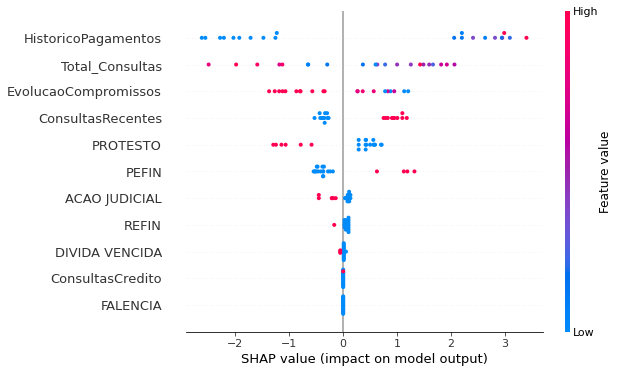

In [18]:
shap.summary_plot(shap_values, X_test)

> ## *Dependence Plot*
Outra fomra de visualizar as informações do grafico acima é através do *Dependence Plot*, que apresenta os valores de cada variável e o quanto eles influenciam no SHAP Value
>> ### HistoricoPagamentos
>> Podemos verificar que valores abaixo de 0 sempre impactam em um resultado negativo, e valores acima disso impactam de ofrma possitiva.

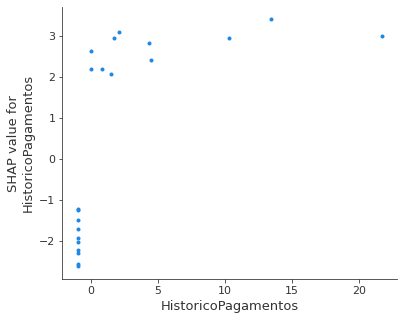

None

In [19]:
display(shap.dependence_plot('HistoricoPagamentos', shap_values, X_test, interaction_index = None))

>> ### ConsultaRecentes
>> Aqui verificamos que quando zerado a ConsultaRecentes, o modelo sempre é impactado para ser negativo. Sendo o oposto verdade.

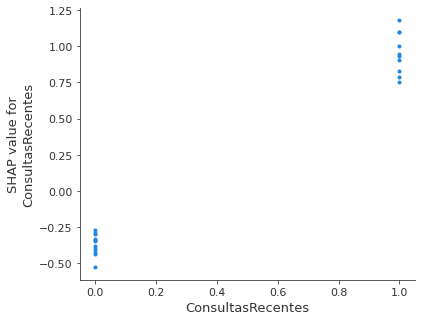

None

In [20]:
display(shap.dependence_plot('ConsultasRecentes', shap_values, X_test, interaction_index = None))

# Conclusões

Dado a quantidade de dados, verificamos os impactos de cada variavel e o quanto ela influencia em um modelo com 86% de accuracy. Chegamos a conclusão que as variaveis binarias adicionadas **PROTESTO** e **PEFIN** influenciaram de fomra positiva ao modelo, entretanto a baixa influencia das outras variaveis não dispensa a utilização delas, apenas que possue um desbalanceamento nos dados encontrados. 